In [1]:
import c14
import c14.models.liver

import numpy as np
import pandas as pd
import scipy as sp
import theano
import theano.tensor as T

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# %autoreload 2
import pymc3 as pm

In [3]:
import scipy
import theano

floatX = theano.config.floatX

class DE(pm.ode.DifferentialEquation):
    def _simulate(self, y0, theta):
        # Initial condition comprised of state initial conditions and raveled sensitivity matrix
        s0 = np.concatenate([y0, self._sens_ic])
        
        # perform the integration
        sol = scipy.integrate.solve_ivp(
            fun = lambda t, Y: self._system(Y, t, tuple(np.concatenate([y0, theta]))),
            t_span=[0, self._augmented_times.max()],
            y0=s0,
            method='RK45',
            t_eval=self._augmented_times,
            atol=1e99, rtol=1e99,
            max_step=0.02).y.T.astype(floatX)
        
        # The solution
        y = sol[1:, :self.n_states]

        # The sensitivities, reshaped to be a sequence of matrices
        sens = sol[1:, self.n_states:].reshape(self.n_times, self.n_states, self.n_p)

        return y, sens

In [4]:
path = c14.models.liver.default_path

In [5]:
UnivariateSpline = sp.interpolate.UnivariateSpline

In [6]:
ploidy_data = pd.read_excel(path)

ploidy_data['age'] = (ploidy_data[['age_min', 'age_max']].
                              mean(axis='columns'))
ploidy_data /= 100.0
ploidy_data['age'] *= 100

ploidy = UnivariateSpline(ploidy_data['age'].values,
                               ploidy_data['2C_mean'].values,
                               ext=3, k=2)
dtploidy = ploidy.derivative()
ploidy2x2 = UnivariateSpline(ploidy_data['age'].values,
                                  ploidy_data['2Cx2_mean'].values,
                                  ext=3, k=2)

In [7]:
t0 = np.linspace(0, 100, 50)
p0 = ploidy(t0)
dtp0 = dtploidy(t0)
p2x20 = ploidy2x2(t0)
years = np.linspace(1900, 2020, 50)
Catm0 = c14.models.liver.Catm().lin(years)


def ploidy(t):
    C0 = p0
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

def ploidy2x2(t):
    C0 = p2x20
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

def dtploidy(t):
    C0 = dtp0
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

def Catm(t):
    t0 = years
    C0 = Catm0
    C = 0
    for i in range(len(t0)-1):
        C += (t>=t0[i]) * (t<t0[i+1]) * (C0[i]*(t0[i+1]-t) + C0[i+1]*(t-t0[i]))/(t0[i+1] - t0[i])
    return C

In [8]:
data = pd.read_csv('../data/C14data_liver_samples_20191023.csv')
data = data.groupby(['type', 'sample', 'ploidy', 'pathology']).mean().dropna(how='all').reset_index()
data['age'] = data['Dcoll'] - data['Dbirth']
data = data.query('type == "hepatocyte" and pathology != "Y"')
# data = data.query('ploidy == "2n4n"')
data = data[['sample', 'ploidy', 'Dbirth', 'age', 'd14C']]
# data['d14C'] *= 1000
data = data.sort_values('age')

# data = data.head(10)

data_unstack = (data
                .set_index('d14C', drop=False)
                .set_index(['sample', 'ploidy', 'Dbirth', 'age', 'age'], append=True)
                .unstack().T.loc['d14C'])
# for a in np.arange(0.0, data['age'].max(), 10):
#     if not a in data_unstack.index:
#         data_unstack.loc[a] = np.nan
data_unstack = data_unstack.sort_index()

age = data_unstack.index.values
d14C_obs = np.ma.masked_invalid(data_unstack.values).T

Dbirth = data_unstack.columns.to_frame()['Dbirth'].values
subject_age = data_unstack.columns.to_frame()['age'].values
ploidy_type = data_unstack.columns.to_frame()['ploidy'].values
d14C_obs_1 = data_unstack.columns.to_frame()['d14C'].values
n = data_unstack.shape[1]

mask_n2n4 = ploidy_type == '2n4n'
mask_n2 = ploidy_type == '2n'
mask_n4 = ploidy_type == '4n'

wn2 = np.empty_like(subject_age) 
wn4 = np.empty_like(subject_age) 

wn2[mask_n2n4] = ploidy(subject_age[mask_n2n4])
wn2[mask_n2] = ploidy(subject_age[mask_n2])
wn2[mask_n4] = 0

wn4[mask_n2n4] = 2*(1-ploidy(subject_age[mask_n2n4]))
wn4[mask_n2] = 2*ploidy2x2(subject_age[mask_n2])
wn4[mask_n4] = 1

wn2, wn4 = wn2/(wn2 + wn4), wn4/(wn2 + wn4)

scaled_age = 1

In [9]:
def ode_C_func(C, t, p):
    lambda_ = p[0]
    if isinstance(C, T.TensorVariable):
        dC = lambda_*(Catm(t + Dbirth) - C) * T.where(t<=subject_age, T.ones_like(C),
                                                 T.zeros_like(C))
    else:
        dC = lambda_*(Catm(t + Dbirth) - C) * np.where(t<=subject_age, np.ones_like(C),
                                                 np.zeros_like(C))
    return_string = '[' 
    for i in range(n):
        return_string += f'dC[{i}], '
    return_string += ']'
    return eval(return_string)

In [10]:
lambda_true = 0.1
sigma_true = 0.01

In [11]:
t_sim = age

In [12]:
%%time 
s = sp.integrate.solve_ivp(lambda t, y: ode_C_func(y, t, tuple([[lambda_true]])),
                                   t_span=[0, age.max()],
                                   y0=Catm(Dbirth),
                                   method='BDF',
                                   t_eval=age,
                          atol=1e-6,
                          rtol=1e-3)

CPU times: user 4.05 s, sys: 2.48 s, total: 6.53 s
Wall time: 587 ms


In [13]:
np.random.seed(42)
yobs = np.random.normal(s.y, sigma_true)
yobs = np.ma.array(yobs, mask=d14C_obs.mask)

In [14]:
yobs.shape

(41, 33)

In [15]:
y_1 = np.empty_like(Dbirth)
yobs_1 = np.empty_like(Dbirth)
for i in np.arange(0, yobs.shape[0]):
    y_1[i] = s.y[i, yobs[i].mask == False]
    yobs_1[i] = yobs[i, yobs[i].mask == False]
# yobs = np.ma.array(yobs, mask=mask)

In [16]:
# plt.plot(Dbirth, Catm(Dbirth), marker='s', ls='None')
# plt.plot(Dbirth, yobs[:,0], marker='s', ls='None')

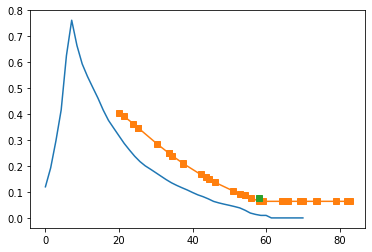

In [17]:
t = np.linspace(0, 70)
plt.plot(t, Catm(t+Dbirth[3]))
plt.plot(t_sim, s.y[3, :], marker='s')
plt.plot(t_sim, yobs[3,:], marker='s')
plt.show()

In [18]:
d14Cdata = d14C_obs_1

In [19]:
def ode_C_func_scaled(C, t, p):
    lambda_ = p[0] 
    t *= subject_age / scaled_age
    
    dC = (subject_age / scaled_age) * lambda_*(Catm(t + Dbirth) - C)
    
    return [dC[i] for i in range(n)]

In [20]:
s2 = sp.integrate.solve_ivp(lambda t, y: ode_C_func_scaled(y, t, tuple([[lambda_true]])),
                                   t_span=[0, scaled_age],
                                   y0=Catm(Dbirth),
                                   method='BDF',
                                   t_eval=[scaled_age],
                           rtol=1e-3, atol=1e-6)

In [22]:
ode_C_model = DE(ode_C_func_scaled, times=[scaled_age], n_states=n, n_theta=1)

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [23]:
with pm.Model() as POP1:
    log10_lambda = pm.Uniform('log10_lambda', -3, 0)
    lambda_ = pm.Deterministic('lambda_', 10**log10_lambda)
    sigma = pm.HalfNormal('sigma', 0.01)
    
    ode_C_solution = ode_C_model(y0=Catm(Dbirth), theta=[lambda_]).T.reshape(d14Cdata.shape)
    
    d14C = pm.Normal('d14C', mu=ode_C_solution, sd=sigma, observed=d14Cdata)

    trace1 = pm.sample(draws=200, tune=100, compute_convergence_checks=False, chains=1)

INFO (theano.gof.compilelock): Refreshing lock /home/fabrost/.theano/compiledir_Linux-4.12-lp151.28.25-default-x86_64-with-glibc2.10-x86_64-3.7.3-64/lock_dir/lock
Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/fabrost/.theano/compiledir_Linux-4.12-lp151.28.25-default-x86_64-with-glibc2.10-x86_64-3.7.3-64/lock_dir/lock
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, log10_lambda]
Sampling chain 0, 0 divergences:   3%|▎         | 8/300 [03:25<2:46:31, 34.22s/it]/home/fabrost/miniconda3/envs/spols191122/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
Sampling chain 0, 0 divergences:   3%|▎         | 8/300 [03:35<2:11:04, 26.93s/it]


In [ ]:
pm.plot_posterior(trace1['lambda_'])

In [ ]:
with pm.Model() as POP1:
    lambda_ = pm.Uniform('lambda_', 0, 1, testval=0.1)
    sigma = pm.HalfNormal('sigma', 0.01)
    
    ode_C_solution = ode_C_model(y0=Catm(Dbirth), theta=[lambda_]).T.reshape(d14Cdata.shape)
    
    d14C = pm.Normal('d14C', mu=ode_C_solution, sd=sigma, observed=d14Cdata)

    trace1 = pm.sample(draws=200, tune=100, compute_convergence_checks=False, chains=1)

In [ ]:
pm.plot_posterior(trace1['lambda_'])

## 2n/4n

In [ ]:
def delta2_D(r2, r4, kappa24, kappa42, t):
    return -kappa24 - kappa42 + r2 + kappa42/ploidy(t) - (dtploidy(t)*(1 + ploidy(t))**2)/(2.*ploidy(t))

def delta4_D(r2, r4, kappa24, kappa42, t):
    return -(dtploidy(t)*(1 + ploidy(t))**2 + 4*(-kappa42 + r4 + (2*kappa24 + kappa42 - r4)*ploidy(t)))/(4.*(-1 + ploidy(t)))

In [ ]:
def ode_C2C4_func_scaled(y, t, p):
    t *= (subject_age / scaled_age)
    C2 = y[:n]
    C4 = y[n:]
    
    r2 = p[0]
    r4 = p[1]
    kappa24 = p[2]
    kappa42 = p[3]
    
    delta2 = delta2_D(r2, r4, kappa24, kappa42, t)
    delta4 = delta4_D(r2, r4, kappa24, kappa42, t)
#     assert (delta2 > 0).all()
#     assert (delta4 > 0).all()
    
    dC2 = (subject_age / scaled_age) *(C2*kappa42 - C4*kappa42 - C2*r2 + r2*Catm(Dbirth + t) + ((-C2 + C4)*kappa42)/ploidy(t))
    dC4 = (subject_age / scaled_age) * ((-(C4*(delta4 + kappa42 - 2*r4)) + (-(C2*kappa24) + C4*(delta4 + 4*kappa24 + kappa42 - 2*r4))*ploidy(t) + Catm(Dbirth + t)*(-r4 + (-kappa24 + r4)*ploidy(t)))/(-1 + ploidy(t)))
    return [dC2[i] for i in range(n)] + [dC4[i] for i in range(n)]

In [ ]:
r2_true = 0.1
r4_true = 0.02
kappa24_true = 0.01
kappa42_true = 0.001

In [ ]:
s = sp.integrate.solve_ivp(lambda t, y: ode_C2C4_func_scaled(y, t,
                                                             [r2_true, r4_true,
                                                                     kappa24_true, kappa42_true]),
                                   t_span=[0, scaled_age],
                                   y0=np.concatenate([Catm(Dbirth), Catm(Dbirth)]),
                                   method='RK45',
                                   t_eval=[scaled_age])

In [ ]:
C2 = s.y[:n, 0]
C4 = s.y[n:, 0]
y = wn2*C2 + wn4*C4

np.random.seed(42)
yobs = np.random.normal(loc=y, scale=sigma_true)

In [ ]:
%%time
ode_C2C4_model = DE(ode_C2C4_func_scaled, times=[scaled_age], n_states=2*n, n_theta=4)

In [ ]:
%%time
Cdata = yobs

with pm.Model() as D:
    lower = 0
    upper = 1.0
    
    r2 = pm.Uniform('r2', lower, upper, testval=0.1)
    r4 = pm.Uniform('r4', testval=0.1)
    kappa24 = pm.Uniform('kappa24', testval=0.1)
    kappa42 = pm.Uniform('kappa42', testval=0.1)
    
    sigma = pm.Uniform('sigma', lower, upper, testval=0.1)
    
    test_times = np.linspace(0, subject_age.max(), 10)
    for t in test_times:
        pm.Potential(f'delta2_{t}',
                     (delta2_D(r2, r4, kappa24, kappa42, t)<0) * delta2_D(r2, r4, kappa24, kappa42, t)**2)
        pm.Potential(f'delta4_{t}',
                     (delta4_D(r2, r4, kappa24, kappa42, t)<0) * delta4_D(r2, r4, kappa24, kappa42, t)**2)
    
    ode_C2C4_solution = ode_C2C4_model(y0=np.concatenate([Catm(Dbirth), Catm(Dbirth)]), 
                                       theta=[r2, r4, kappa24, kappa42])
    
    C2 = ode_C2C4_solution[0, :n]
    C4 = ode_C2C4_solution[0, n:]
    mu = wn2*C2 + wn4*C4
    
    d14C = pm.Normal('d14C', mu=mu, sd=sigma, observed=Cdata)
#     map_ = pm.find_MAP()
    trace2 = pm.sample(500, tune=100, compute_convergence_checks=False)
#     approx2 = pm.fit(n=10000)

In [ ]:
len(trace2)